## Imports
---

In [100]:
#external
import pandas as pd

#visualization
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

#sklearn
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score 
from sklearn.metrics import recall_score, confusion_matrix, roc_auc_score, roc_curve, auc

#oversampling
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

#utils
from src.utils.dataset import get_full_transactions_dataset 

## Dataset
---

In [3]:
df = get_full_transactions_dataset().sample(50000)

2025-03-05 17:40:20.309 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2025-03-05 17:40:20.310 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-05 17:40:20.730 
  command:

    streamlit run C:\Users\ferna\AppData\Roaming\Python\Python312\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-03-05 17:40:20.731 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-05 17:40:20.732 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-05 17:40:21.251 Thread 'Thread-6': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-05 17:40:21.252 Thread 'Thread-6': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-05 17:40:28.287 Thread 'Ma

In [4]:
df.dtypes

timestamp              object
sender                 object
receiver               object
amount_received       float64
receiving_currency     object
amount_paid           float64
payment_currency       object
payment_format         object
is_laundering           int64
dtype: object

In [5]:
df.isna().sum()

timestamp             0
sender                0
receiver              0
amount_received       0
receiving_currency    0
amount_paid           0
payment_currency      0
payment_format        0
is_laundering         0
dtype: int64

In [6]:
df.head()

,timestamp,sender,receiver,amount_received,receiving_currency,amount_paid,payment_currency,payment_format,is_laundering
3275105,2022/09/07 00:35,2385_8023677B0,1420_803F09250,5696715.87,US Dollar,5696715.87,US Dollar,Cheque,0
4910037,2022/09/10 03:12,795_8089A5FC0,228540_80D050BC0,110.46,US Dollar,110.46,US Dollar,Cheque,0
3764150,2022/09/08 00:49,116843_8070A96B0,4_807167320,68080.08,Ruble,68080.08,Ruble,Credit Card,0
28375,2022/09/01 00:12,8354_80371E780,8354_80371E780,12.10,US Dollar,12.10,US Dollar,Reinvestment,0
2814095,2022/09/06 01:45,70_100428660,9371_80E15AD00,348.14,US Dollar,348.14,US Dollar,Cheque,0


In [7]:
df.is_laundering.value_counts(True)

is_laundering
0    0.99912
1    0.00088
Name: proportion, dtype: float64

## Tranformations
---

In [8]:
def custom_transformations(dataframe: pd.DataFrame) -> pd.DataFrame:
    dataframe = dataframe.drop(columns=["sender", "receiver"])
    dataframe["timestamp"] = pd.to_datetime(dataframe["timestamp"])
    dataframe["timestamp"] = dataframe["timestamp"].apply(lambda timestamp_value: timestamp_value.value)
    return dataframe

In [9]:
df = custom_transformations(df)

## Train
---

### Train & Test split

In [10]:
X = df.drop(columns=["is_laundering"])
y = df["is_laundering"]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((40000, 6), (10000, 6), (40000,), (10000,))

In [13]:
y_train.value_counts(True), y_test.value_counts(True) 

(is_laundering
 0    0.99915
 1    0.00085
 Name: proportion, dtype: float64,
 is_laundering
 0    0.999
 1    0.001
 Name: proportion, dtype: float64)

### Pipeline

In [14]:
categorical_columns = X.select_dtypes(include="object").columns
numerical_columns = X.select_dtypes(exclude="object").columns

In [15]:
numerical_pipeline = Pipeline([
    ("scaler", MinMaxScaler())
])

categorical_pipeline = Pipeline([
    ("encoder", OrdinalEncoder())
])

preprocess = ColumnTransformer([
    ("numerical_pipeline", numerical_pipeline, numerical_columns),
    ("categorical_pipeline", categorical_pipeline, categorical_columns)
])

In [16]:
X_train = preprocess.fit_transform(X_train)
X_test = preprocess.transform(X_test)

### Oversampling (SMOTE)

In [17]:
oversample = SMOTE(random_state=42, sampling_strategy=0.1)
X_train_resample, y_train_resample = oversample.fit_resample(X_train, y_train)

In [18]:
y_train_resample.value_counts(), y_test.value_counts() 

(is_laundering
 0    39966
 1     3996
 Name: count, dtype: int64,
 is_laundering
 0    9990
 1      10
 Name: count, dtype: int64)

### Grid search

In [19]:
grid_parameter = {
    "max_depth": [4, 8, 16],
    "n_estimators": [100, 200, 300],
    "max_features": [20, 40, 80]
}

In [20]:
grid = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=grid_parameter,
    cv=3,
    scoring="roc_auc", 
    verbose=3)

model_grid = grid.fit(X_train_resample, y_train_resample)

print(f"Best parameters: {model_grid.best_params_}")
print(f"Best score is: {model_grid.best_score_}")

Best parameters: {'max_depth': 16, 'max_features': 20, 'n_estimators': 300}

## Testing best model

In [87]:
full_dataframe = get_full_transactions_dataset()

In [88]:
fraud_transactions_df = full_dataframe[full_dataframe["is_laundering"] == 1]
non_fraud_transactions_df = full_dataframe[full_dataframe["is_laundering"] == 0].sample(int(50e3))
sample_dataframe = pd.concat([fraud_transactions_df, non_fraud_transactions_df])

In [89]:
sample_dataframe.is_laundering.value_counts()

is_laundering
0    50000
1     5177
Name: count, dtype: int64

In [90]:
sample_dataframe.shape[0]

55177

In [91]:
sample_dataframe = custom_transformations(sample_dataframe)

In [92]:
X = sample_dataframe.drop(columns=["is_laundering"])
y = sample_dataframe["is_laundering"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = preprocess.fit_transform(X_train)
X_test = preprocess.transform(X_test)

oversample = SMOTE(random_state=42, sampling_strategy=0.1)
X_train_resample, y_train_resample = oversample.fit_resample(X_train, y_train)

model = RandomForestClassifier(max_depth=16, max_features=20, n_estimators=300)

model.fit(X_train_resample, y_train_resample)

In [93]:
full_pipeline = ImbPipeline([
    ("preprocess", preprocess), 
    ("smote", SMOTE(random_state=42, sampling_strategy=0.5)),
    ("model", RandomForestClassifier(max_depth=16, max_features=20, n_estimators=300, random_state=42))
])

In [94]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

In [95]:
cross_validation_result = cross_validate(
    full_pipeline,
    X,
    y,
    cv=cv,
    scoring=("f1", "accuracy", "roc_auc"),
    verbose=3
)

[CV] END  accuracy: (test=0.936) f1: (test=0.698) roc_auc: (test=0.913) total time=  52.6s
[CV] END  accuracy: (test=0.938) f1: (test=0.703) roc_auc: (test=0.919) total time=  52.3s
[CV] END  accuracy: (test=0.934) f1: (test=0.690) roc_auc: (test=0.920) total time=  54.1s


## Evaluate

In [96]:
y_pred = cross_val_predict(full_pipeline, X, y, cv=cv)
y_pred_prob = cross_val_predict(full_pipeline, X, y, cv=cv, method='predict_proba')[:, 1]

In [97]:
acc = accuracy_score(y, y_pred)
print(f'Accuracy: {acc:.4f}')

f1 = f1_score(y, y_pred)  
print(f'F1 Score: {f1:.4f}')

precision = precision_score(y, y_pred)
print(f'Precision: {precision:.4f}')

recall = recall_score(y, y_pred)
print(f'Recall: {recall:.4f}')

auc_score = roc_auc_score(y, y_pred_prob)
print(f'AUC: {auc_score:.4f}')

Accuracy: 0.9360
F1 Score: 0.6969
Precision: 0.6270
Recall: 0.7844
AUC: 0.9173


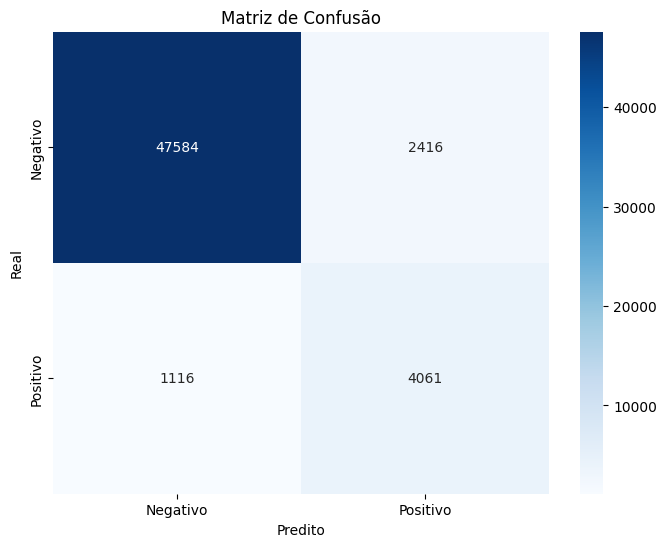

In [98]:
cm = confusion_matrix(y, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negativo', 'Positivo'], yticklabels=['Negativo', 'Positivo'])
plt.title('Matriz de Confusão')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.show()

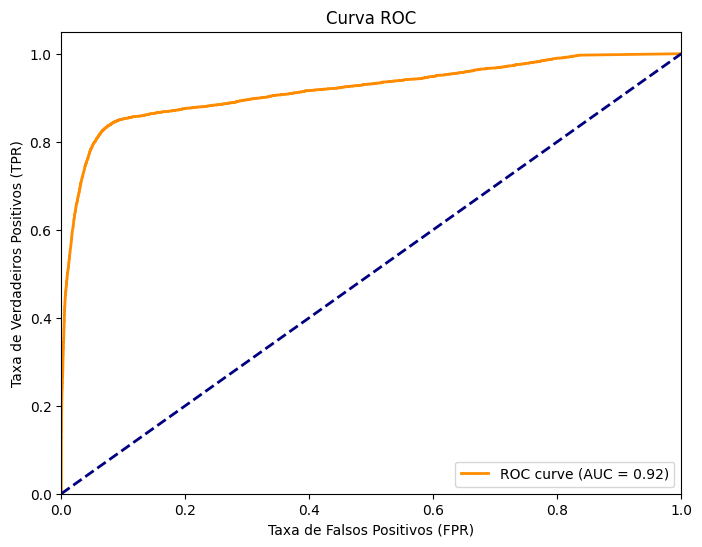

In [101]:
fpr, tpr, thresholds = roc_curve(y, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()